In [75]:
import networkx as nx
import numpy as np
import pandas as pd

# for the explode statement; convert string to list
from ast import literal_eval

# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 

In [76]:
def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5): 

    adjacency = nx.to_scipy_sparse_matrix(G, nodelist=None, dtype=None, weight='weight', format='csr') 

    names = np.array(list(G.nodes())) 

    graph = Bunch() 
    graph.adjacency = adjacency 
    graph.names = np.array(names) 

    pagerank = PageRank() 

    scores = pagerank.fit_transform(adjacency) 

    if show_names: 
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width) 

    else: 

        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width) 

    return SVG(image) 

# Create Graph using Bipartite Projection on Arxiv Dataset

In [77]:
data = r'C:\Users\groov\PythonCode\100daysofnetworks\data\arxiv_network_science_data.csv'

df = pd.read_csv(data)

df = pd.read_csv(data)
df['authors'] = df['authors'].apply(literal_eval)

df = df[['authors', 'title']]
df = df.explode('authors')
df.reset_index(drop=True, inplace=True)

# fix the & so that scikit-network stops crashing
df['authors'] = df['authors'].str.replace('&', 'and')
df['title'] = df['title'].str.replace('&', 'and')

df.head()

,authors,title
0,Dustin Nguyen,Neural ODEs as a discovery tool to characteriz...
1,Yuan-Sen Ting,Neural ODEs as a discovery tool to characteriz...
2,Todd A. Thompson,Neural ODEs as a discovery tool to characteriz...
3,Sebastian Lopez,Neural ODEs as a discovery tool to characteriz...
4,Laura A. Lopez,Neural ODEs as a discovery tool to characteriz...


In [78]:
from networkx.algorithms import bipartite

B = nx.from_pandas_edgelist(df, source='authors', target='title')
G = bipartite.projected_graph(B, df['authors'])

G = nx.k_core(G, 2) # no isolates or two-node groups

In [79]:
print(nx.info(G))

Graph with 65260 nodes and 306509 edges


In [80]:
nx.density(G) # very sparse

0.00014394140677587773

In [81]:
degree_df = pd.DataFrame(G.degree)
degree_df.columns = ['node', 'degrees']

degree_df.head()

,node,degrees
0,Dustin Nguyen,4
1,Yuan-Sen Ting,37
2,Todd A. Thompson,4
3,Sebastian Lopez,4
4,Laura A. Lopez,4


<AxesSubplot:ylabel='Frequency'>

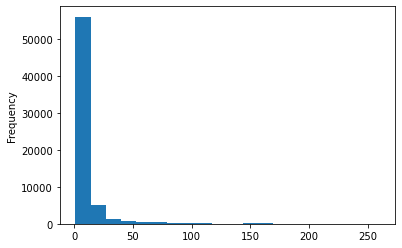

In [82]:
degree_df['degrees'].plot.hist(bins=20)

# Network Attack Simulation

Today, I am trying a very aggressive attack on a large collaboration network. The goal isn't just to disrupt the network but to be able to see the network structures that can withstand such an attack. In each loop, many nodes are removed at once to cause maximum disruption WITHOUT completely destroying the network

# Simulation 1: Iterative Attack

In [83]:
# need for iteration

def get_key_node_df(G):
    
    G = G.copy()
    
    cent_df = pd.DataFrame(nx.pagerank(G), index=[0]).T # cent = centrality

    cent_df.columns = ['pagerank'] # betweenness centrality
    cent_df.sort_values('pagerank', inplace=True, ascending=False)
    
    return cent_df

In [84]:
G1 = G.copy() # keep G for use with simulation 2

#draw_graph(nx.k_core(G1,3), show_names=False, node_size=3) # will take a long time

In [182]:
def remove_nodes(G, iterations=50, cut_size=500):
    
    results = {}
    
    G = G.copy()
    
    for i in range(iterations):
        
        results[i] = {}
        
        results[i]['nodes'] = len(G.nodes)
        results[i]['edges'] = len(G.edges)
        
        print('running loop: {}'.format(i))
    
        cent_df = get_key_node_df(G)

        drop_nodes = sorted(cent_df[0:cut_size].index)
        
        #print('removing key nodes: {}'.format(drop_nodes))

        G.remove_nodes_from(drop_nodes)

        G = nx.k_core(G, 2) # no isolates or two-node groups

        print(nx.info(G))
        
        print()
        print('---------------')
        print()
        
    return G, results

In [86]:
G1, results = remove_nodes(G1, iterations=50)

running loop: 0
Graph with 57619 nodes and 283677 edges

---------------

running loop: 1
Graph with 56438 nodes and 270568 edges

---------------

running loop: 2
Graph with 55415 nodes and 258991 edges

---------------

running loop: 3
Graph with 54379 nodes and 246397 edges

---------------

running loop: 4
Graph with 53542 nodes and 234412 edges

---------------

running loop: 5
Graph with 52780 nodes and 224854 edges

---------------

running loop: 6
Graph with 52039 nodes and 218559 edges

---------------

running loop: 7
Graph with 51160 nodes and 212944 edges

---------------

running loop: 8
Graph with 49829 nodes and 207485 edges

---------------

running loop: 9
Graph with 48202 nodes and 202914 edges

---------------

running loop: 10
Graph with 47173 nodes and 194372 edges

---------------

running loop: 11
Graph with 45893 nodes and 190417 edges

---------------

running loop: 12
Graph with 44929 nodes and 184552 edges

---------------

running loop: 13
Graph with 43993 n

In [98]:
result_df = pd.DataFrame(results).T
result_df['nodes_dropped'] = result_df['nodes'].diff(1).abs()
result_df['edges_dropped'] = result_df['edges'].diff(1).abs()
result_df.fillna(0, inplace=True)
result_df.head()

,nodes,edges,nodes_dropped,edges_dropped
0,65260,306509,0.0,0.0
1,57619,283677,7641.0,22832.0
2,56438,270568,1181.0,13109.0
3,55415,258991,1023.0,11577.0
4,54379,246397,1036.0,12594.0


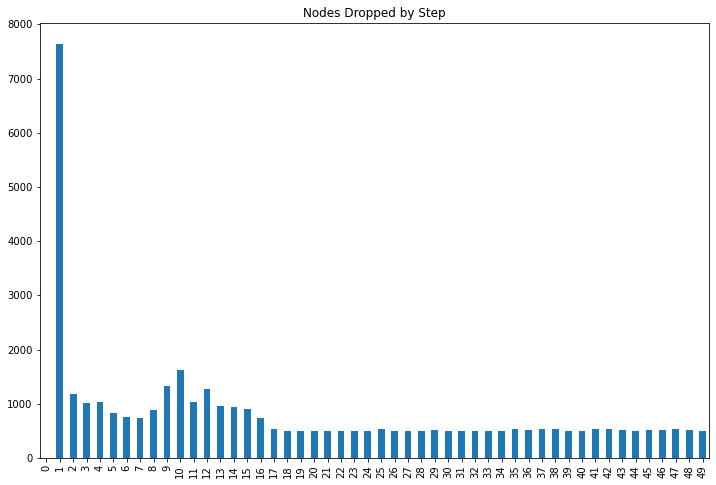

In [185]:
_= result_df['nodes_dropped'].plot.bar(figsize=(12,8), title='Nodes Dropped by Step')

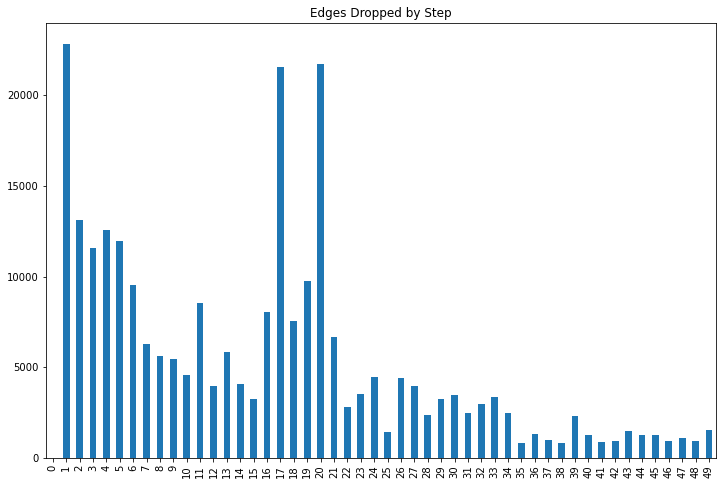

In [187]:
_= result_df['edges_dropped'].plot.bar(figsize=(12,8), title='Edges Dropped by Step')

In [104]:
# learning at each iteration
# speeding up at each step, because smaller networks
# betweenness centrality and shortest path related things are very slow on larger networks
# pagerank can be used instead
# use a centrality that can determine importance beyond number of edges; goal is to cut bridge nodes
# attack options are only limited by creativity

# on complex network, might need larger cut sizes to be effective
# goal was to shatter the network as quickly as possible

# collaborative networks seem to be more resilient in nature; considering that some papers have dozens of authors

# Investigate Surviving Structures

In [105]:
def show_component_count(components, cutoff=4):

    i = 0
    
    for c in components:
        
        if len(c) > cutoff:

            print('c: {} - len: {}'.format(i, len(c)))

        i += 1

In [167]:
def draw_component(G, component, show_names=False):
    
    G = G.copy()

    G_check = G.subgraph(component)

    return draw_graph(G_check, show_names=show_names, node_size=3)

In [168]:
components = list(nx.connected_components(G))
len(components)

6927

In [169]:
show_component_count(components, 40)

c: 0 - len: 77
c: 1 - len: 33249
c: 234 - len: 49
c: 378 - len: 47
c: 569 - len: 53
c: 763 - len: 86
c: 810 - len: 62
c: 816 - len: 121
c: 1012 - len: 42
c: 1277 - len: 74
c: 1346 - len: 57
c: 1366 - len: 48


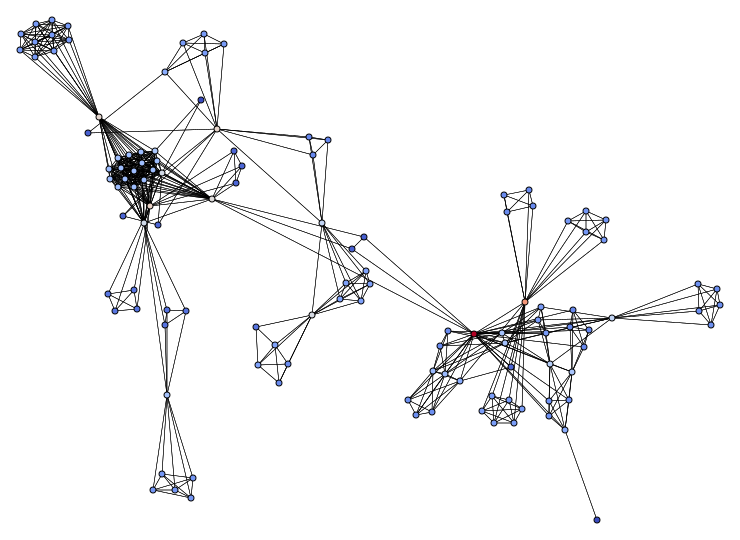

In [172]:
component = components[816]

draw_component(G, component)

In [173]:
components = list(nx.connected_components(G1))
len(components)

6287

In [174]:
show_component_count(components, 9)

c: 53 - len: 10
c: 56 - len: 10
c: 92 - len: 10
c: 1019 - len: 10
c: 1022 - len: 10
c: 1389 - len: 10
c: 1824 - len: 10
c: 2224 - len: 10
c: 2629 - len: 10
c: 2686 - len: 10
c: 2986 - len: 10
c: 3009 - len: 10
c: 3520 - len: 10
c: 3940 - len: 10
c: 4024 - len: 10
c: 4354 - len: 10
c: 4516 - len: 10
c: 4544 - len: 10
c: 4872 - len: 10
c: 4917 - len: 10
c: 4931 - len: 10
c: 5829 - len: 10


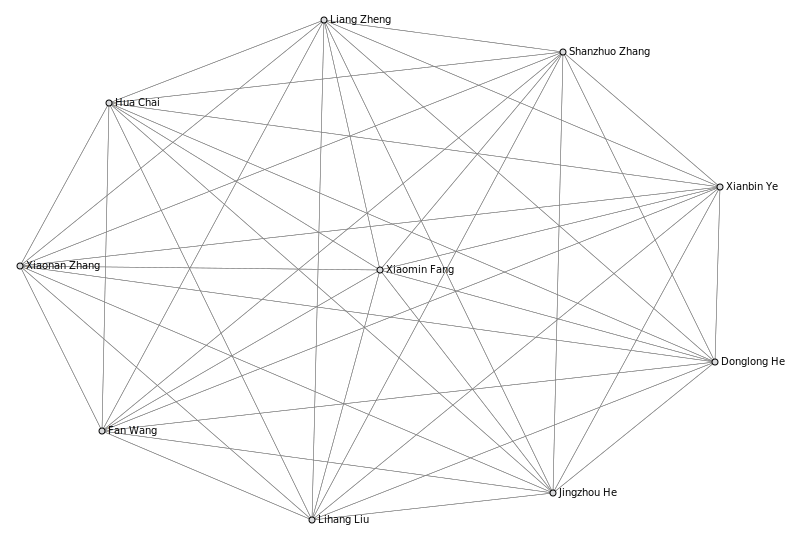

In [179]:
component = components[53]

draw_component(G1, component, show_names=True)

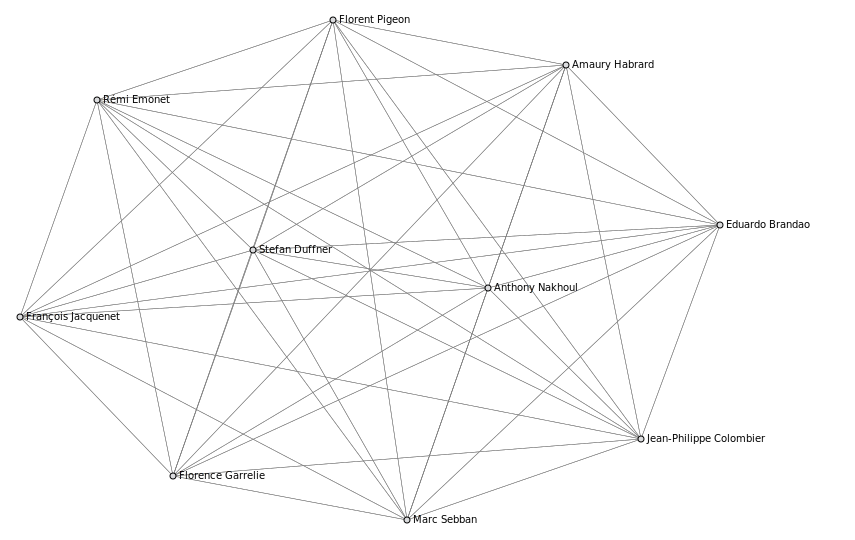

In [180]:
component = components[56]

draw_component(G1, component, show_names=True)

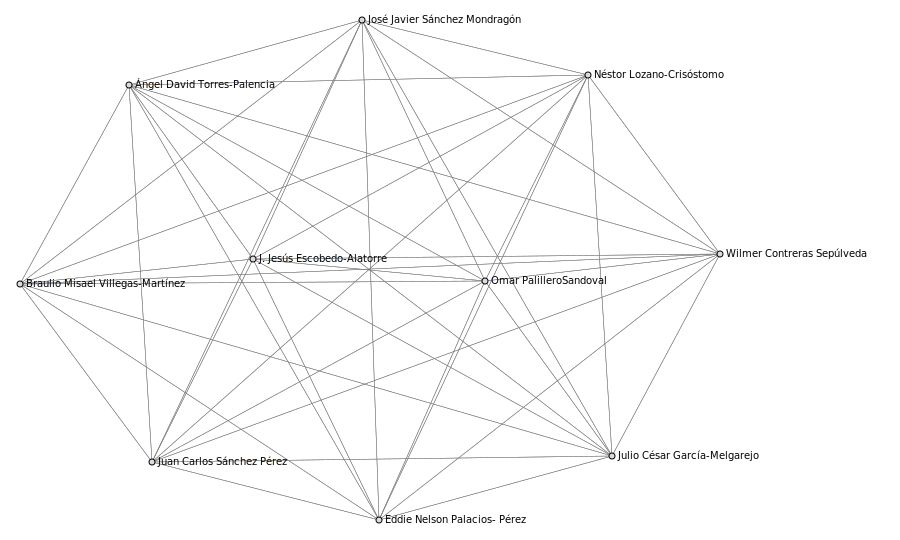

In [181]:
component = components[92]

draw_component(G1, component, show_names=True)

In [132]:
print(nx.info(G))

Graph with 65260 nodes and 306509 edges


In [133]:
print(nx.info(G1))

Graph with 24861 nodes and 41899 edges


In [130]:
nx.density(G) # very sparse

0.00014394140677587773

In [131]:
nx.density(G1) # very sparse

0.0001355857149823817

In [140]:
degree_df = pd.DataFrame(G.degree)
degree_df.columns = ['node', 'degrees']

degree_df.head()

,node,degrees
0,Dustin Nguyen,4
1,Yuan-Sen Ting,37
2,Todd A. Thompson,4
3,Sebastian Lopez,4
4,Laura A. Lopez,4


<AxesSubplot:ylabel='Frequency'>

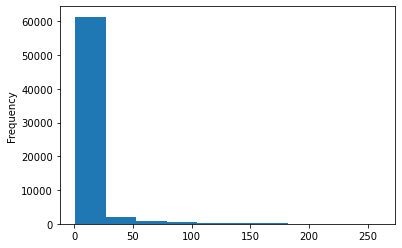

In [141]:
degree_df['degrees'].plot.hist()

In [142]:
degree_df = pd.DataFrame(G1.degree)
degree_df.columns = ['node', 'degrees']

degree_df.head()

,node,degrees
0,Patrick Schünke,3
1,Christoph Kolbitsch,3
2,Tobias Schäffter,3
3,Stefanie Remmele,3
4,Purvik Patel,2


<AxesSubplot:ylabel='Frequency'>

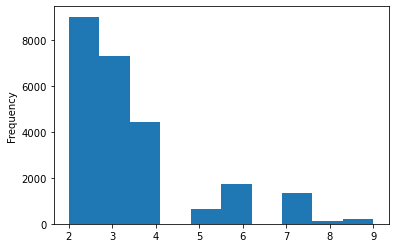

In [143]:
degree_df['degrees'].plot.hist()

In [144]:
nodes = [len(G.nodes), len(G1.nodes)]
edges = [len(G.edges), len(G1.edges)]

<AxesSubplot:>

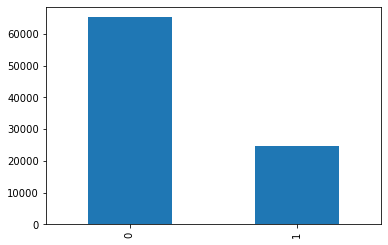

In [162]:
final_df = pd.DataFrame({'nodes':nodes, 'edges':edges})
final_df.sort_index(ascending=True, inplace=True)

final_df['nodes'].plot.bar()

<AxesSubplot:>

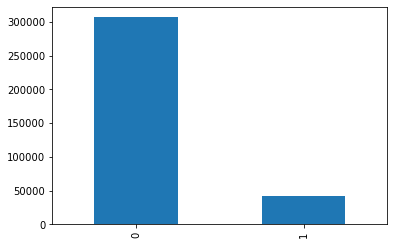

In [164]:
final_df['edges'].plot.bar()

In [188]:
final_df

,nodes,edges
0,65260,306509
1,24861,41899
